In [1]:
from omegaconf import OmegaConf

import numpy as np
from core.models import OveralyNetwokManager, LocalObs, update_detections
from core.utils import (
    Adj_to_Lap,
    Lap_to_Adj,
    run_consensus,
    get_DoS,
    DPMSR_update_neighbors,
    get_PE_algebraic_connectivity,
)
from copy import deepcopy

from plotting import *

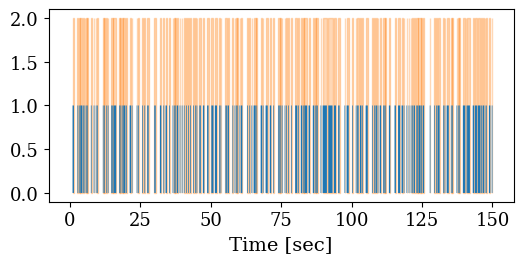

In [2]:
cfg = OmegaConf.load("configs/exp2.yaml")
DoS = get_DoS(p=cfg.DoS.p, num_dos=cfg.DoS.n, t_s=cfg.Ts, t_end=cfg.T_end, seed=80658)

depection-free case | DoS-only:

In [3]:
#
dwell_times = cfg.dwell_times
Adj_1 = np.load("configs/Adj_84_part1.npy")
Adj_2 = np.load("configs/Adj_84_part2.npy")
Adj_overlay = np.load("configs/Adj_84.npy")
Adj = [Adj_1, Adj_2]
N = len(Adj[0])
Ts = cfg.Ts
t_end = cfg.T_end
alpha = cfg.alpha
gamma = cfg.gamma
px0 = np.arange(1, N + 1)  # np.array(cfg.IC.px)
vx0 = 0 * px0  # np.array(cfg.IC.vx)


def threshold_fn(t):
    _k, _L, _eps = 10, 1, cfg.threshold
    return _k * np.exp(-_L * t) + _eps


# ==== initilization =======
X = np.hstack((px0, vx0))
coop_agents = np.arange(N)

agents_detections = {}
observers = []
PO, VO = [], []
PO += [px0]  # positions
VO += [vx0]  # velocities

network_manager = OveralyNetwokManager(
    Adj_overlay, comm_radios=np.inf, dwell_times=dwell_times
)
for id in range(N):
    obs = LocalObs(id, cfg, threshold_fn, px0[id], vx0[id])
    observers += [obs]

# ==== main loop =======
k = 0
while (k * Ts) < t_end:
    t = k * Ts  # time
    X = np.hstack((PO[-1], VO[-1]))
    status, phi = network_manager.update(
        time=t, agents_states=X, DDoS=DoS[k], agents_detections=agents_detections
    )
    # obs
    for id in range(N):
        if id in coop_agents:
            observers[id].update_detect_and_logdata(t, phi[id], status)

    # collect the list of N agents' detected adversarial neighbors, if any
    agents_detections = update_detections(agents_detections, observers, coop_agents)

    # update control
    Lap = network_manager.data.Lap[-1]
    U = -alpha * Lap.dot(PO[-1]) - gamma * VO[-1]

    # first-order Euler approx.
    PO += [PO[-1] + Ts * VO[-1]]
    VO += [VO[-1] + Ts * U]

    k += 1  # time increment

PO = np.array(PO)
VO = np.array(VO)
comm_data_O = deepcopy(network_manager.data)

(-5.0, 90.0)

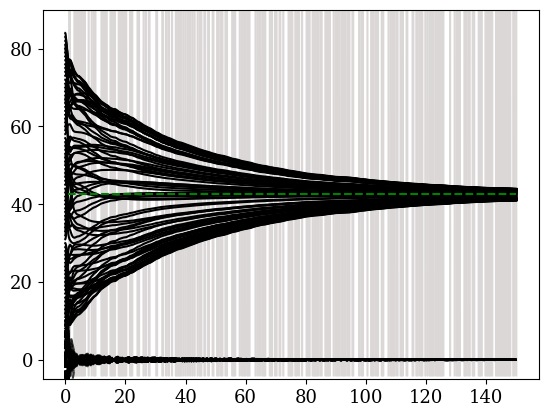

In [4]:
T = np.linspace(0, cfg.T_end, np.int64(cfg.T_end / cfg.Ts) + 1)
plt.fill_between(T, 90 * DoS, color="#dbd7d7")
plt.fill_between(T, -4 * DoS, color="#dbd7d7")
plt.plot(T, PO[:, coop_agents], "k")
plt.plot(T, VO[:, coop_agents], "--k", alpha=0.5)
plt.axhline(y=np.average(PO[0, :]), xmin=0.05, xmax=0.955, linestyle="--", color="g")
plt.ylim([-5, 90])

Adversarial case:

In [5]:
#
dwell_times = cfg.dwell_times
Adj = np.load("configs/Adj_84.npy")
Adj_1 = np.load("configs/Adj_84_part1.npy")
Adj_2 = np.load("configs/Adj_84_part2.npy")
Adj_overlay = np.load("configs/Adj_84.npy")
Adj = [Adj_1, Adj_2]
N = len(Adj[0])
Ts = cfg.Ts
t_end = cfg.T_end
alpha = cfg.alpha
gamma = cfg.gamma
px0 = np.arange(1, N + 1)  # np.array(cfg.IC.px)
vx0 = 0 * px0  # np.array(cfg.IC.vx)

adversaries_ID = cfg.Adversaries.ID


def threshold_fn(t):
    _k, _L, _eps = 10, 1, cfg.threshold
    return _k * np.exp(-_L * t) + _eps


# ==== initilization =======
X = np.hstack((px0, vx0))
adv = np.eye(N)
adv[adversaries_ID, adversaries_ID] = 0  # to make u_n = 0 (equ. 5 in the paper)
coop_agents = np.setdiff1d(np.arange(N), adversaries_ID)

agents_detections = {}
observers = []
P, V, Ua = [], [], np.zeros(N)
P += [px0]  # positions
V += [vx0]  # velocities

network_manager = OveralyNetwokManager(
    Adj_overlay, comm_radios=np.inf, dwell_times=dwell_times
)
for id in range(N):
    obs = LocalObs(id, cfg, threshold_fn, px0[id], vx0[id])
    observers += [obs]

# ==== main loop =======
k = 0
while (k * Ts) < t_end:
    t = k * Ts  # time
    X = np.hstack((P[-1], V[-1]))
    status, phi = network_manager.update(
        time=t, agents_states=X, DDoS=DoS[k], agents_detections=agents_detections
    )
    # obs
    for id in range(N):
        if id in coop_agents:
            observers[id].update_detect_and_logdata(t, phi[id], status)

    # collect the list of N agents' detected adversarial neighbors, if any
    agents_detections = update_detections(agents_detections, observers, coop_agents)

    # update control
    Ua[adversaries_ID[0]] = 0.005 * t
    Ua[adversaries_ID[1]] = -0.001 * t
    Ua[adversaries_ID[2]] = 0.003 * t**2
    Ua[adversaries_ID[3]] = -0.007 * t
    Ua[adversaries_ID[4]] = (
        -10 * (np.pi / 5) ** 2 * np.sin(2 * np.pi * t / 10)
        - (
            P[-1][adversaries_ID[4]]
            - 7 * np.sin(2 * np.pi * t / 10)
            - P[0][adversaries_ID[4]]
        )
        - (V[-1][adversaries_ID[4]] - 10 * np.pi / 5 * np.cos(2 * np.pi * t / 10))
    )
    Ua[adversaries_ID[5]] = 0.001 * np.exp(1 * t)
    Ua[adversaries_ID[6]] = -0.04 * t
    Ua[adversaries_ID[7]] = 0.002 * t
    Ua[adversaries_ID[8]] = 0
    Lap = network_manager.data.Lap[-1]
    U = -alpha * (adv @ Lap).dot(P[-1]) - gamma * (adv @ np.eye(N)).dot(V[-1]) + Ua

    # first-order Euler approx.
    P += [P[-1] + Ts * V[-1]]
    V += [V[-1] + Ts * U]

    k += 1  # time increment

P = np.array(P)
V = np.array(V)

coop. agent 33 at t=0.42, detected neigh. [32]
coop. agent 34 at t=0.42, detected neigh. [32]
coop. agent 67 at t=0.42, detected neigh. [32]
coop. agent 35 at t=0.43, detected neigh. [32]
coop. agent 41 at t=0.43, detected neigh. [32]
coop. agent 42 at t=0.78, detected neigh. [18]
coop. agent 43 at t=0.79, detected neigh. [18]
coop. agent 19 at t=0.8300000000000001, detected neigh. [18]
coop. agent 20 at t=0.84, detected neigh. [18]
coop. agent 31 at t=0.84, detected neigh. [32]
coop. agent 11 at t=0.85, detected neigh. [0]
coop. agent 21 at t=0.85, detected neigh. [18]
coop. agent 1 at t=0.86, detected neigh. [0]
coop. agent 24 at t=0.86, detected neigh. [0]
coop. agent 50 at t=0.9, detected neigh. [32]
coop. agent 80 at t=0.9, detected neigh. [32]
coop. agent 13 at t=0.93, detected neigh. [3]
coop. agent 22 at t=0.96, detected neigh. [3]
coop. agent 58 at t=0.99, detected neigh. [59]
coop. agent 78 at t=0.99, detected neigh. [59]
coop. agent 2 at t=2.0300000000000002, detected neigh.

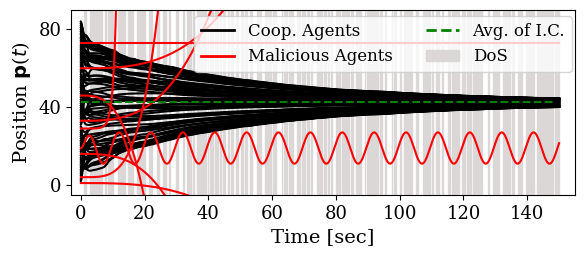

In [6]:
T = np.linspace(0, cfg.T_end, np.int64(cfg.T_end / cfg.Ts) + 1)

plt.figure(figsize=(6.5, 2.4))
plt.fill_between(T, 90 * DoS, where=(DoS > 0), color="#dbd7d7")
plt.fill_between(T, -10 * DoS, where=(DoS > 0), color="#dbd7d7")
plt.plot(T, P[:, coop_agents], "k")
# plt.plot(T, V[:, coop_agents], "--k")
plt.plot(T, P[:, adversaries_ID], "r")
# plt.plot(T, V[:, adversaries_ID], "--r")
plt.axhline(y=np.average(P[0, :]), xmin=0.02, xmax=0.956, linestyle="--", color="g")
plt.xlabel(r"Time [sec]")
plt.ylim([-5, 90])
plt.xlim([-3, 155])
plt.yticks([0, 40, 80])
# plt.xticks([0, 30, 60, 90, 120, 150])
plt.ylabel(r"Position $\mathbf{p}$($\mathit{t}$)")

legend_lines = [
    Line2D([0], [0], color="k", lw=2, label=r"Coop. Agents"),
    Line2D([0], [0], color="r", lw=2, label=r"Malicious Agents"),
    # Line2D([0], [0], color="tab:gray", alpha=0.95, lw=2, label=r"w/o Malicious Agents"),
    Line2D([0], [0], color="green", linestyle="--", lw=2, label=r"Avg. of I.C."),
]

legend_patches = [mpatches.Patch(color="#dbd7d7", label=r"DoS")]

plt.legend(
    handles=legend_lines + legend_patches,
    loc="upper right",
    bbox_to_anchor=(0, 0.81, 1.01, 0.2),
    ncol=2,
    # mode="expand",
    fontsize=12,
)
# plt.savefig("results/exp2_pos_.pdf", bbox_inches="tight")

Comparion with the DM-MSR algorithm: 
# https://www.sciencedirect.com/science/article/abs/pii/S0005109817301310
# https://www.sciencedirect.com/science/article/abs/pii/S0167691115000419

We provide the DM-MSR algorithm with the accessibility benefit of the complete Adj_overlay. 
In other words, it uses the union of the subgraphs Adj_1 and Adj_2 that were used in the proposed approach above.

In [7]:
# cfg = OmegaConf.load("configs/exp2.yaml")
Adj = np.load("configs/Adj_84.npy")

ORIGINAL_PARAMS = False

if ORIGINAL_PARAMS:
    # a fixed lower bound on communication links encoded in the adjacency matrix:
    gamma = 1 / Adj.sum(axis=1).max()
    # the paper does not report the gamma value
    # Yet, alpha = 1/d, where d is the maximum in-degree of agents meet the
    # conditions specided in Section 2.1 of the Dibaji's paper paper.
    alpha = cfg.gamma
    Ts = 0.5
    duration = 800
else:
    # check out the footnoe attached to Equation (9) in the Dibaji's paper (Elsevier 2017).
    # use the parameter as in ./configs/
    gamma = cfg.alpha  # note gamma & alpha are different here !
    alpha = cfg.gamma
    Ts = cfg.Ts
    duration = cfg.T_end

if ORIGINAL_PARAMS and any(np.sum(Adj * gamma, axis=1) > 1):
    print(
        "Warning! decrease the value of gamma! and check Section 2.1 of the Dibaji paper"
    )
    # Condition on sample-time Ts and parameter alpha:
    if not (1 + Ts ^ 2 / 2 <= alpha * Ts and alpha * Ts <= 2 - Ts ^ 2 / 2):
        print(
            "Error: sample-time, Ts, and control gain, alpha, do not meet the condition (9) of the Dibaji paper"
        )


Adj = Adj * gamma
N = len(Adj)

px0 = np.arange(1, N + 1)  # np.array(cfg.IC.px)
vx0 = 0 * px0

adversaries_ID = cfg.Adversaries.ID


# ==== initilization =======
adv = np.eye(N)
adv[adversaries_ID, adversaries_ID] = 0
coop_agents = np.setdiff1d(np.arange(N), adversaries_ID)

agents_detections = {}
P_msr, V_msr, Ua = [], [], np.zeros(N)
Z1, Z2 = [], []
P_msr += [px0]
V_msr += [vx0]
Z1 += [px0]
Z2 += [vx0]

# ==== main loop =======
k = 0
while (k * Ts) < duration:
    t = k * Ts

    adj_cur = DPMSR_update_neighbors(
        x=P_msr[-1], F=1, Adj=Adj, malicious_agents=[4], threshold=0
    )

    # update control
    Lap = Adj_to_Lap(adj_cur) * (1 - DoS[k])

    Ua[adversaries_ID[0]] = 0.005 * t
    Ua[adversaries_ID[1]] = -0.001 * t
    Ua[adversaries_ID[2]] = 0.003 * t**2
    Ua[adversaries_ID[3]] = -0.007 * t
    Ua[adversaries_ID[4]] = (
        -10 * (np.pi / 5) ** 2 * np.sin(2 * np.pi * t / 10)
        - (
            P_msr[-1][adversaries_ID[4]]
            - 7 * np.sin(2 * np.pi * t / 10)
            - P_msr[0][adversaries_ID[4]]
        )
        - (V_msr[-1][adversaries_ID[4]] - 10 * np.pi / 5 * np.cos(2 * np.pi * t / 10))
    )
    Ua[adversaries_ID[5]] = 0.001 * np.exp(1 * t)
    Ua[adversaries_ID[6]] = -0.04 * t
    Ua[adversaries_ID[7]] = 0.002 * t
    Ua[adversaries_ID[8]] = 0
    U = -(adv @ Lap).dot(P_msr[-1]) - alpha * (adv @ np.eye(N)).dot(V_msr[-1]) + Ua

    # Zero-order hold discretization
    P_msr += [P_msr[-1] + Ts * V_msr[-1] + (Ts**2) / 2 * U]
    V_msr += [V_msr[-1] + Ts * U]

    # adversary-free case
    U_n = -Lap.dot(Z1[-1]) - alpha * Z2[-1]
    Z1 += [Z1[-1] + Ts * Z2[-1] + (Ts**2) / 2 * U_n]
    Z2 += [Z2[-1] + Ts * U_n]

    k += 1  # time increment


P_msr = np.array(P_msr)
V_msr = np.array(V_msr)
Z1 = np.array(Z1)
Z2 = np.array(Z2)

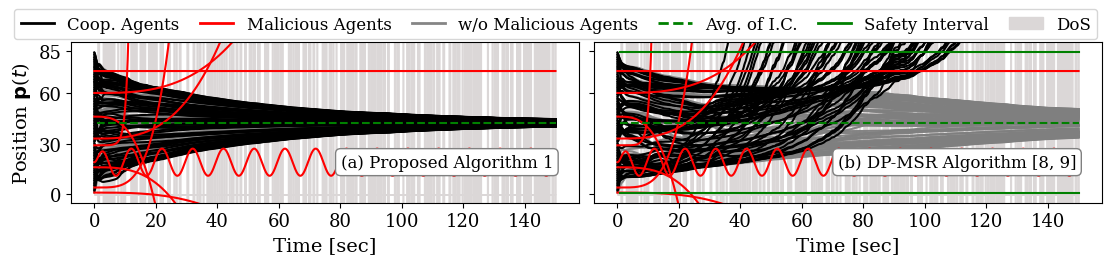

In [8]:
T = np.linspace(0, cfg.T_end, np.int64(cfg.T_end / cfg.Ts) + 1)

plot_pos(
    P=P,
    PO=PO,
    P_msr=P_msr,
    Z1=Z1,
    coop_agents_ID=coop_agents,
    adv_agents_ID=cfg.Adversaries.ID,
    T=T,
    DoS=DoS,
    fig_size=(11, 2.2),
    ylim1=[-5, 90],
    titles=["(a) Proposed Algorithm 1", "(b) DP-MSR Algorithm [8, 9]"],
    yticks1=[0, 30, 60, 85],
    lg_fontsize=12,
    bbox_to_anchor=(0, 0.97, 1, 0.2),
)

# plt.savefig("results/exp2_pos.pdf", bbox_inches="tight")

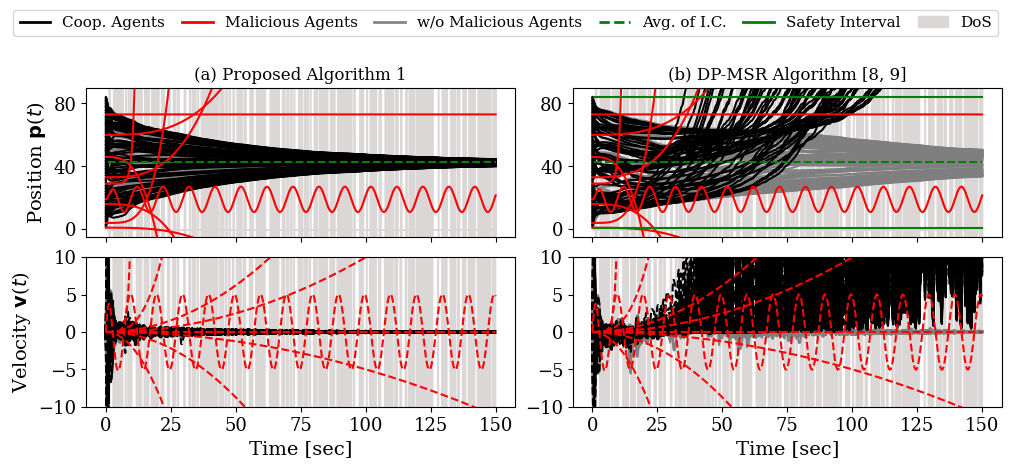

In [9]:
plot_states(
    P=P,
    V=V,
    PO=PO,
    VO=VO,
    P_msr=P_msr,
    V_msr=V_msr,
    Z1=Z1,
    Z2=Z2,
    coop_agents_ID=coop_agents,
    adv_agents_ID=cfg.Adversaries.ID,
    T=T,
    DoS=DoS,
    fig_size=(10, 4),
    ylim1=[-5, 90],
    ylim2=[-10, 10],
    titles=["(a) Proposed Algorithm 1", "(b) DP-MSR Algorithm [8, 9]"],
    yticks1=[0, 40, 80],
)
# plt.savefig("results/exp2_states.pdf", bbox_inches="tight")

collective 1-hops:[1, 3, 12, 13, 22, 23, 24]


(-0.2, 20.0)

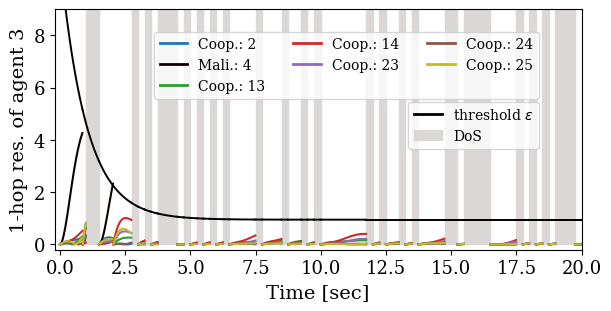

In [13]:
plot_selective_residuals(
    observers,
    coop_agent_ID=2,
    adv_agents_ID=cfg.Adversaries.ID,
    num_modes=None,
    T=T,
    DoS=DoS,
    ylim=[-0.2, 9],
    # yticks=[0, 0.5, 1],
    thre=threshold_fn,
    fig_size=(6, 3),
    bbox1_to_anchor=(0, 0.7, 0.9, 0.2),
    bbox2_to_anchor=(0, 0.5, 0.9, 0.2),
)
plt.xlim([-0.2, 20])
# plt.savefig("results/exp2_res_50.pdf", bbox_inches="tight")

algebraic connectivity in (mu,T)-PE sense

In [14]:
mu, integ_Adj, mu_bar, integ_iAdj, lambda2, bar_lambda2 = get_PE_algebraic_connectivity(
    comm_data=network_manager.data,
    T=100,
    T_end=cfg.T_end,
    Ts=cfg.Ts,
    coop_ID=coop_agents,
)
mu_0, _, _, _, lambda2_0, _ = get_PE_algebraic_connectivity(
    comm_data=comm_data_O, T=100, T_end=cfg.T_end, Ts=cfg.Ts
)

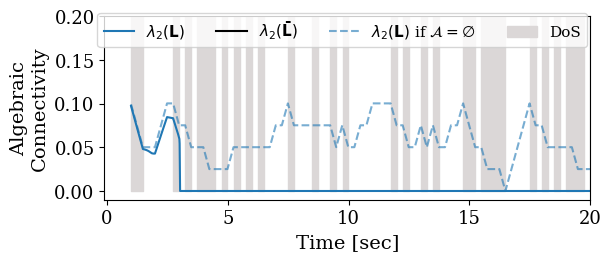

In [16]:
def plot_algebraic_connectivity(
    mu,
    mu_bar,
    mu_0,
    lambda2,
    bar_lambda2,
    Ts,
    T_end,
    T_PE=0,
    t_d=[0],
    DoS=None,
    fig_size=(6, 3),
    ylim=None,
    xlim=None,
    yticks=None,
):
    fig, ax = plt.subplots(figsize=fig_size, layout="constrained")

    T = np.linspace(0, T_end, np.int64(T_end / Ts) + 1)
    i_PE = np.int64(T_PE / Ts)
    itr_d = np.int64(t_d[-1] / Ts)

    if DoS is not None:
        gain = max(lambda2) * 1.1 if ylim is None else ylim[1]
        ax.fill_between(T, gain * DoS, where=(DoS > 0), color="#dbd7d7")

    # ax.plot(
    #     T,
    #     lambda2,
    #     color="tab:red",
    #     alpha=0.8,
    #     linewidth=0.9,
    #     label=r"$\lambda_{2}(\mathsf{L}_{\sigma})$",
    # )
    ax.plot(
        T[i_PE:],
        mu[i_PE:],
        color="tab:blue",
        # label=r"$\hat{\mu} = \lambda_{2}(\mathbf{L})$",
        label=r"$\lambda_{2}(\mathbf{L})$",
    )
    # ax.plot(
    #     T[itr_d:],
    #     bar_lambda2[itr_d:],
    #     color="tab:brown",
    #     alpha=0.8,
    #     linewidth=0.9,
    #     label=r"${\lambda}_{2}(\mathsf{\bar{L}}_{\sigma})$",
    # )
    ax.plot(
        T[itr_d:],
        mu_bar[itr_d:],
        color="k",
        # label=r"$\hat{\bar{\mu}} = \lambda_{2}(\mathbf{\bar{L}})$",
        label=r"$\lambda_{2}(\mathbf{\bar{L}})$",
    )
    ax.plot(
        T[i_PE:],
        mu_0[i_PE:],
        color="tab:blue",
        alpha=0.6,
        linestyle="--",
        label=r"$\lambda_{2}(\mathbf{L})$ if $\mathcal{A}=\emptyset$",
    )

    for t in t_d:
        ax.axvline(x=t, color="tab:gray", linestyle="--")

    ax.set_ylabel(r"Algebraic" + "\n" + r"Connectivity")
    if ylim is not None:
        ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)
    if xlim is not None:
        ax.set_xlim(xlim)

    ax.set_xlabel(r"Time [sec]")

    legend_handles, legend_labels = ax.get_legend_handles_labels()

    # Create a separate legend for specific lines
    legend_patches = [mpatches.Patch(color="#dbd7d7", label=r"DoS")]

    # legend_handles_ = [legend_handles[id] for id in [1, 3, 4]]

    fig.legend(
        handles=legend_handles + legend_patches,
        # + legend_patches,
        # labels=legend_labels + [r"DoS"],
        bbox_to_anchor=(0.14, 0.8, 0.99, 0.2),
        loc="upper left",
        ncol=4,
        # mode="expand",
        fontsize=11,  # "small",
    )
    # fig.legend(
    #     handles=legend_patches,
    #     bbox_to_anchor=(0, 0.7, 0.99, 0.2),
    #     fontsize=11,
    # )


plot_algebraic_connectivity(
    mu=mu,
    mu_bar=mu_bar,
    mu_0=mu_0,
    lambda2=lambda2,
    bar_lambda2=bar_lambda2,
    Ts=cfg.Ts,
    T_end=cfg.T_end,
    T_PE=1,
    t_d=[28.66],
    DoS=DoS,
    fig_size=(6, 2.5),
    ylim=[-0.01, 0.2],
    xlim=[-0.1, 20],
    # yticks=[0, 0.2],
)
# plt.savefig("results/exp1_alg_conn.pdf", bbox_inches="tight")

by t=0.9 the G is disconneced from adv. node 32